# Loading libraries

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from core import AD, Cluster, MLModel, Visualization
from data import Datasets, Preprocess, Features

In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt

from pycaret import classification,regression

# Getting dataset

In [5]:
datasets = Datasets(dtype="interpolated")

In [6]:
datasets.info()

Database is 'starrydata(interpolated)'


In [7]:
datasets.get_versions()

['20220519',
 '20220228',
 '20220207',
 '20211124',
 '20210927',
 '20210611',
 '20210415',
 '20210216',
 '20210201',
 '20201222',
 '20201002',
 '20200818',
 '20200201',
 '20191119']

In [8]:
df_data_tmp = datasets.get_alldata(version="20210927")

datasets/
finished: datasets/interpolated_starrydata_20210927.csv


In [9]:
df_data_tmp.head(2)

,sid,DOI,published,projectname,sampleid,samplename,composition,sampleinfo,Temperature,Seebeck coefficient,figureid,Thermal conductivity,Electrical resistivity,Carrier mobility,ZT,Electrical conductivity,Power factor,Figure of merit Z,Hall movility,Lattice thermal conductivity,thermopower,phonon thermal conductance,Carrier thermal conductivity,phonon contribution,Electronic thermal conductivity,Electronic contribution,hall density,Carrier concentration,Hall coefficient,Calculated Electrical Conductivity,Calculated PF,Figure of merit,Calculated Electrical Conductivity/ Relaxation time,Calculated Seebeck coefficient,Calculated Thermal Conductivity/ Relaxation time,Thermal diffusivity,total thermal conductivity,Lattice contribution,latice contribution,electron thermal conductivity,Figure of merit Zt,Electro Motive Force,Mobility,Nernst coefficient,Electrical conductivity0,Thermopower,Thermoelectric voltage,Thermo gravimetry,Thermal conductance,conductance,TEP,T^(-1),S,Seebeck coefficient,Voltage,Max Efficiency,Normalised PL Integrated Intensity,Linewidth,Phonon transmission function,ρ,Lorenz values,magnetoresistance,Resistance,Conductivity,Luminescence lifetime,magnetization_Bohr,inverse susceptibility,Elastic modulus,Coercivity Field,magnetization_per_weight,Resistivity,Remanent Magnetization_Absolute,absolute_magnetization,Open circuit voltage,Hall concentration,Contact resistivity,Magnetic field strength (H),Magnetization,a.u. Magnetic Moment,conductivity,zero-B thermopower,minority carrier concentration,majority carrier concentration,magnetic susceptibility,Magnetic susceptibility_per_weight,Specific heat,Magnetic susceptibility_volume,inverse magnetic susceptibility_mol,Cp,dc magnetization(mass),Calculated Electrical resistivity,Electrical thermal conductivity,Specific heat capacity,Magnetic susceptibility_per mol,Magnetic susceptibility,Specific heat capacity_per g,Seebeck coefficient,Mass susceptibility
0,6,10.1021/am405410e,2014-3-26,['ThermoelectricMaterials'],113,Pb1.00025Zn0.02Te1.02I0.0005,Pb1.00025Zn0.02Te1.02I0.0005,"{'Form': {'category': 'Bulk', 'comment': ''}, ...",300,-0.000148,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,10.1021/am405410e,2014-3-26,['ThermoelectricMaterials'],113,Pb1.00025Zn0.02Te1.02I0.0005,Pb1.00025Zn0.02Te1.02I0.0005,"{'Form': {'category': 'Bulk', 'comment': ''}, ...",350,-0.000172,79,1.917624,0.000011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_data_tmp.shape

(311651, 98)

# Preprocessing data

In [11]:
preprocess = Preprocess()

In [12]:
filtercols = ["composition","published","DOI","Temperature","Seebeck coefficient","Electrical conductivity","Thermal conductivity","ZT"]

In [13]:
#Preprocess1: 
df_data = preprocess.get_dense(df_data_tmp,filtercols)

In [14]:
#Preprocess2: 
df_data["year"]=df_data["published"].apply(preprocess.getyear)

In [15]:
comp_conv_dict = {}
for comp in tqdm(df_data_tmp["composition"].unique()):
    comp_conv = preprocess.set_reduce_formula(comp)
    comp_conv_dict[comp_conv] = comp

  0%|          | 0/19337 [00:00<?, ?it/s]

In [16]:
#Preprocess3: Unification of chemical composition
df_data["composition"] = df_data["composition"].apply(preprocess.set_reduce_formula)

In [17]:
#Preprocess4: Comparison of ZT calculated from S, σ, and κ with recorded ZT
df_data["ZTcalc"] = (((df_data["Seebeck coefficient"]**2)*df_data["Electrical conductivity"])/df_data["Thermal conductivity"])*df_data["Temperature"]
df_data["correlation"] = ((1-(np.abs((df_data["ZTcalc"]-df_data["ZT"])/df_data["ZT"]))).fillna(0) >= 0.95).astype(int)
df_data = df_data[df_data["correlation"]==1]

In [18]:
#Preprocess5: 
df_data = df_data[df_data["composition"]!=""]

In [19]:
df_data=df_data.reset_index(drop=True)

In [20]:
#Preprocess6:
df_data = df_data.dropna()

In [21]:
df_data.shape

(35393, 11)

In [22]:
df_data.head(2)

,composition,published,DOI,Temperature,Seebeck coefficient,Electrical conductivity,Thermal conductivity,ZT,year,ZTcalc,correlation
0,Te205Pb1282S1077Cl,2011-3-16,10.1021/ja109138p,550,-0.000232,31675.090924,1.409117,0.638708,2011,0.666472,1
1,Te205Pb1282S1077Cl,2011-3-16,10.1021/ja109138p,600,-0.000250,24525.986881,1.312606,0.681944,2011,0.698634,1


In [23]:
compT = []
for idx, comp in enumerate(df_data["composition"].values):
    compT.append(comp+"_"+str(df_data["Temperature"].values[idx]))

In [24]:
df_data["compositionT"] = compT

In [25]:
df_data["PFcalc"] = (np.abs(df_data["Seebeck coefficient"])**2)*np.abs(df_data["Electrical conductivity"])*10**3
df_data["Seebeck coefficient"] = np.abs(df_data["Seebeck coefficient"]) * 10**6
df_data["Z"] = (df_data["ZT"] / df_data["Temperature"])*10**3

In [26]:
df_data.head(2)

,composition,published,DOI,Temperature,Seebeck coefficient,Electrical conductivity,Thermal conductivity,ZT,year,ZTcalc,correlation,compositionT,PFcalc,Z
0,Te205Pb1282S1077Cl,2011-3-16,10.1021/ja109138p,550,232.179611,31675.090924,1.409117,0.638708,2011,0.666472,1,Te205Pb1282S1077Cl_550,1.707521,1.161287
1,Te205Pb1282S1077Cl,2011-3-16,10.1021/ja109138p,600,249.633668,24525.986881,1.312606,0.681944,2011,0.698634,1,Te205Pb1282S1077Cl_600,1.528385,1.136573


# Generating vectors

In [27]:
feature = Features()

In [28]:
complist = df_data["composition"]

In [29]:
df_feature = feature.get_comp_descfeatures(complist)

In [30]:
df_feature.shape

(35393, 27)

In [31]:
df_feature.head(3)

,composition,comp_length,compbase_length,ave:Atomic no,var:Atomic no,main_max1min1diff:Atomic no,ave:group,var:group,main_max1min1diff:group,ave:row,var:row,main_max1min1diff:row,ave:Mendeleev no,var:Mendeleev no,main_max1min1diff:Mendeleev no,ave:Atomic mass,var:Atomic mass,main_max1min1diff:Atomic mass,ave:Atomic radius,var:Atomic radius,main_max1min1diff:Atomic radius,ave:X,var:X,main_max1min1diff:X,ave:VEC,var:VEC,main_max1min1diff:VEC
0,Te205Pb1282S1077Cl,4.0,2.0,51.864717,994.452264,66.0,15.00078,1.001169,2.0,4.659259,2.064792,3.0,87.844444,34.4105,12.0,127.235032,7002.267775,175.135,1.431813,0.1462,0.8,2.416912,0.023185,0.25,4.998051,1.009353,2.0
1,Te205Pb1282S1077Cl,4.0,2.0,51.864717,994.452264,66.0,15.00078,1.001169,2.0,4.659259,2.064792,3.0,87.844444,34.4105,12.0,127.235032,7002.267775,175.135,1.431813,0.1462,0.8,2.416912,0.023185,0.25,4.998051,1.009353,2.0
2,Te205Pb1282S1077Cl,4.0,2.0,51.864717,994.452264,66.0,15.00078,1.001169,2.0,4.659259,2.064792,3.0,87.844444,34.4105,12.0,127.235032,7002.267775,175.135,1.431813,0.1462,0.8,2.416912,0.023185,0.25,4.998051,1.009353,2.0


# Preparation of training data

In [32]:
starrfiltercols = ["Temperature",
                     'Seebeck coefficient',
                     'Electrical conductivity',
                     'Thermal conductivity',
                     'Z',
                     'ZTcalc',
                     'PFcalc',
                     'composition',
                     'compositionT',
                     'year',
                      'DOI']

In [33]:
df_starry = preprocess.get_dense(df_data,starrfiltercols)

In [34]:
df_input = pd.concat([df_feature.iloc[:,1:].reset_index(drop=True), df_starry.reset_index(drop=True)], axis=1).dropna()

In [35]:
df_input.shape

(35332, 37)

In [36]:
df_input.head(2)

,comp_length,compbase_length,ave:Atomic no,var:Atomic no,main_max1min1diff:Atomic no,ave:group,var:group,main_max1min1diff:group,ave:row,var:row,main_max1min1diff:row,ave:Mendeleev no,var:Mendeleev no,main_max1min1diff:Mendeleev no,ave:Atomic mass,var:Atomic mass,main_max1min1diff:Atomic mass,ave:Atomic radius,var:Atomic radius,main_max1min1diff:Atomic radius,ave:X,var:X,main_max1min1diff:X,ave:VEC,var:VEC,main_max1min1diff:VEC,Temperature,Seebeck coefficient,Electrical conductivity,Thermal conductivity,Z,ZTcalc,PFcalc,composition,compositionT,year,DOI
0,4.0,2.0,51.864717,994.452264,66.0,15.00078,1.001169,2.0,4.659259,2.064792,3.0,87.844444,34.4105,12.0,127.235032,7002.267775,175.135,1.431813,0.1462,0.8,2.416912,0.023185,0.25,4.998051,1.009353,2.0,550,232.179611,31675.090924,1.409117,1.161287,0.666472,1.707521,Te205Pb1282S1077Cl,Te205Pb1282S1077Cl_550,2011,10.1021/ja109138p
1,4.0,2.0,51.864717,994.452264,66.0,15.00078,1.001169,2.0,4.659259,2.064792,3.0,87.844444,34.4105,12.0,127.235032,7002.267775,175.135,1.431813,0.1462,0.8,2.416912,0.023185,0.25,4.998051,1.009353,2.0,600,249.633668,24525.986881,1.312606,1.136573,0.698634,1.528385,Te205Pb1282S1077Cl,Te205Pb1282S1077Cl_600,2011,10.1021/ja109138p


# Splitting training data and test data

In [37]:
year_th = 2020

In [38]:
df_dataBF = df_input[df_input["year"]<=year_th].copy()

In [39]:
df_dataAF = df_input[df_input["year"]>year_th].copy()

In [40]:
df_dataAF = df_dataAF[df_dataAF["composition"].apply(preprocess.is_comp,df_compare=df_dataBF)]

In [41]:
df_dataBF.shape,df_dataAF.shape

((33788, 37), (1265, 37))

# Applicability Doamin

In [42]:
ad = AD()

In [43]:
inputsize = 27
k=9

In [44]:
df_ad_train = df_dataBF.drop_duplicates("compositionT")
df_ad_train = df_ad_train.reset_index(drop=True)
df_ad_train = df_ad_train.iloc[:,:inputsize]

In [45]:
#AD: get threshold
nn_train, th_train = ad.get_threshold(df_ad_train,k=k)

In [46]:
df_ad_test_tmp = df_dataAF.drop_duplicates("compositionT")
df_ad_test = df_ad_test_tmp.copy()
df_ad_test = df_ad_test.reset_index(drop=True)
df_ad_test = df_ad_test.iloc[:,:inputsize]

In [47]:
#AD: apply AD
filterAD = ad.count_AD(nn_train,df_ad_test,th_train) > 0
ad_reliability = ad.count_AD(nn_train,df_ad_test[filterAD],th_train)

# Clustering

In [48]:
cl = Cluster()
viz = Visualization()

In [49]:
clusters, matfamily, df_cluster = cl.get_matfamily_cluster(df_dataBF, inputsize, kind="BGM",clusternum = 15, covariance_type="tied", random_state=10)

In [50]:
yclist = cl.get_year_cluster_list(df_cluster, clusters)

In [51]:
matcolor, sort_matfamily = cl.get_matfamily_matcolor(df_cluster, matfamily)

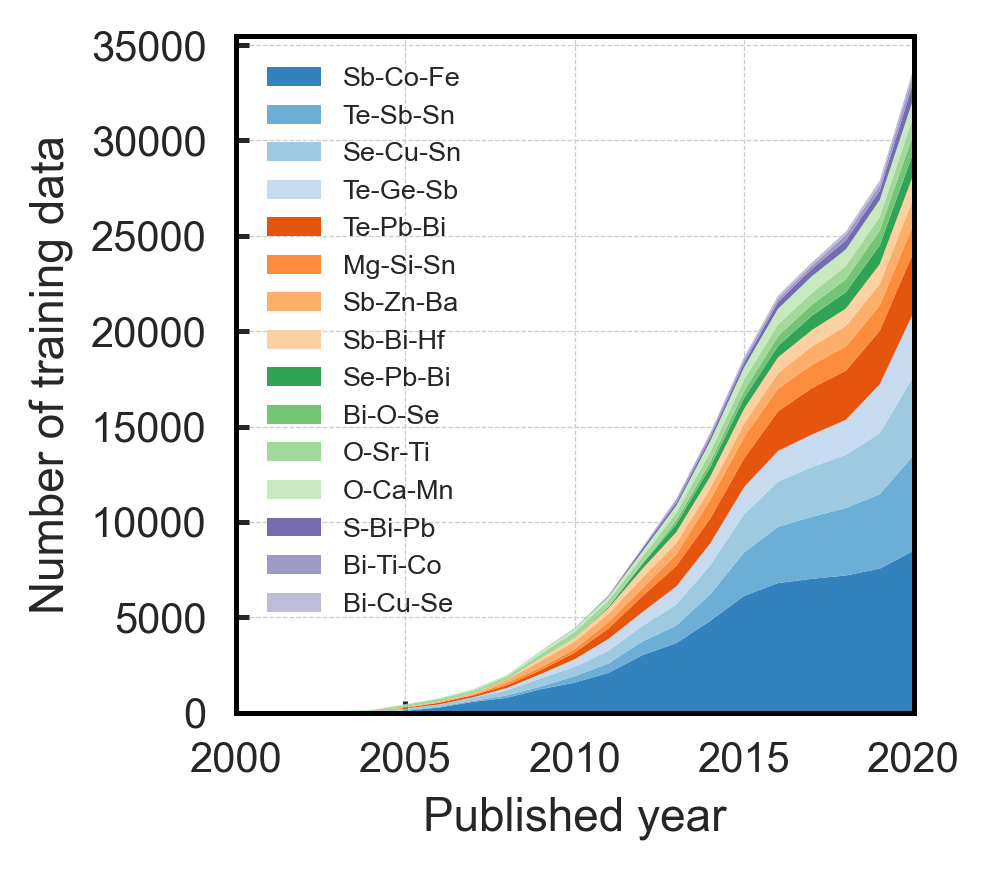

In [52]:
viz.save_numofdata_years_cluster(yclist, matfamily, df_cluster)

# Machine learning

In [53]:
df_train = df_dataBF.copy()
df_train = df_train.drop(["composition","compositionT","year"], axis=1)
df_train = df_train
df_test_inAD = df_ad_test_tmp[filterAD].copy()
df_test_inAD_save = df_ad_test_tmp[filterAD].copy()
df_test_outAD = df_ad_test_tmp[~filterAD].copy()
df_test_outAD_save = df_ad_test_tmp[~filterAD].copy()
df_test_inAD = df_test_inAD.drop(["composition","compositionT","year"], axis=1)
df_test_outAD = df_test_outAD.drop(["composition","compositionT","year"], axis=1)

In [54]:
targets = ['Seebeck coefficient','Electrical conductivity','Thermal conductivity','Z']

In [55]:
mlmodel = MLModel()

In [56]:
mlmodel.compare_models(targets[0], df_train, inputsize)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,17.3254,1205.1133,34.6730,0.8293,0.1864,0.1141,2.8040
et,Extra Trees Regressor,16.7802,1245.7613,35.2420,0.8234,0.1900,0.1112,1.0430
dt,Decision Tree Regressor,19.9182,1595.4957,39.8491,0.7737,0.2194,0.1323,0.0540
lightgbm,Light Gradient Boosting Machine,28.4690,2065.5305,45.4153,0.7078,0.2515,0.1915,0.0610
gbr,Gradient Boosting Regressor,41.0130,3778.1449,61.4288,0.4656,0.3485,0.2935,0.7790
knn,K Neighbors Regressor,39.0279,3901.8541,62.4214,0.4481,0.3482,0.2701,0.0230
ada,AdaBoost Regressor,55.6277,5487.7827,74.0553,0.2229,0.4490,0.4163,0.3140
lr,Linear Regression,55.2423,6081.9786,77.9578,0.1393,0.4665,0.4298,0.1210
ridge,Ridge Regression,55.2415,6087.3239,77.9917,0.1385,0.4664,0.4293,0.0150
br,Bayesian Ridge,55.2517,6095.1581,78.0417,0.1374,0.4665,0.4290,0.0210


In [57]:
tune_params = {'max_depth': [50, 100, 500],
             'n_estimators': [100, 300, 500]}

In [58]:
models = mlmodel.create_ad_starrydata_models(targets, df_train, inputsize, tune_params)

  0%|          | 0/4 [00:00<?, ?it/s]

create
tune
Transformation Pipeline and Model Successfully Saved
create
tune
Transformation Pipeline and Model Successfully Saved
create
tune
Transformation Pipeline and Model Successfully Saved
create
tune
Transformation Pipeline and Model Successfully Saved


In [59]:
targets = ['Seebeck coefficient','Electrical conductivity','Thermal conductivity','ZTcalc']

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


,Seebeck coefficient,Electrical conductivity,Thermal conductivity,ZTcalc
mape,23.219312,80.240171,35.474149,78.998501
rmsle,0.085382,0.019189,0.188332,0.040884
mape_out,23.665563,497.292338,59.840244,123.705883
rmsle_out,0.110506,0.001408,0.219974,0.028750
r2_score,0.472431,0.205026,0.027508,-0.570654
r2_score_out,-0.286688,-0.898874,-0.358941,0.252505


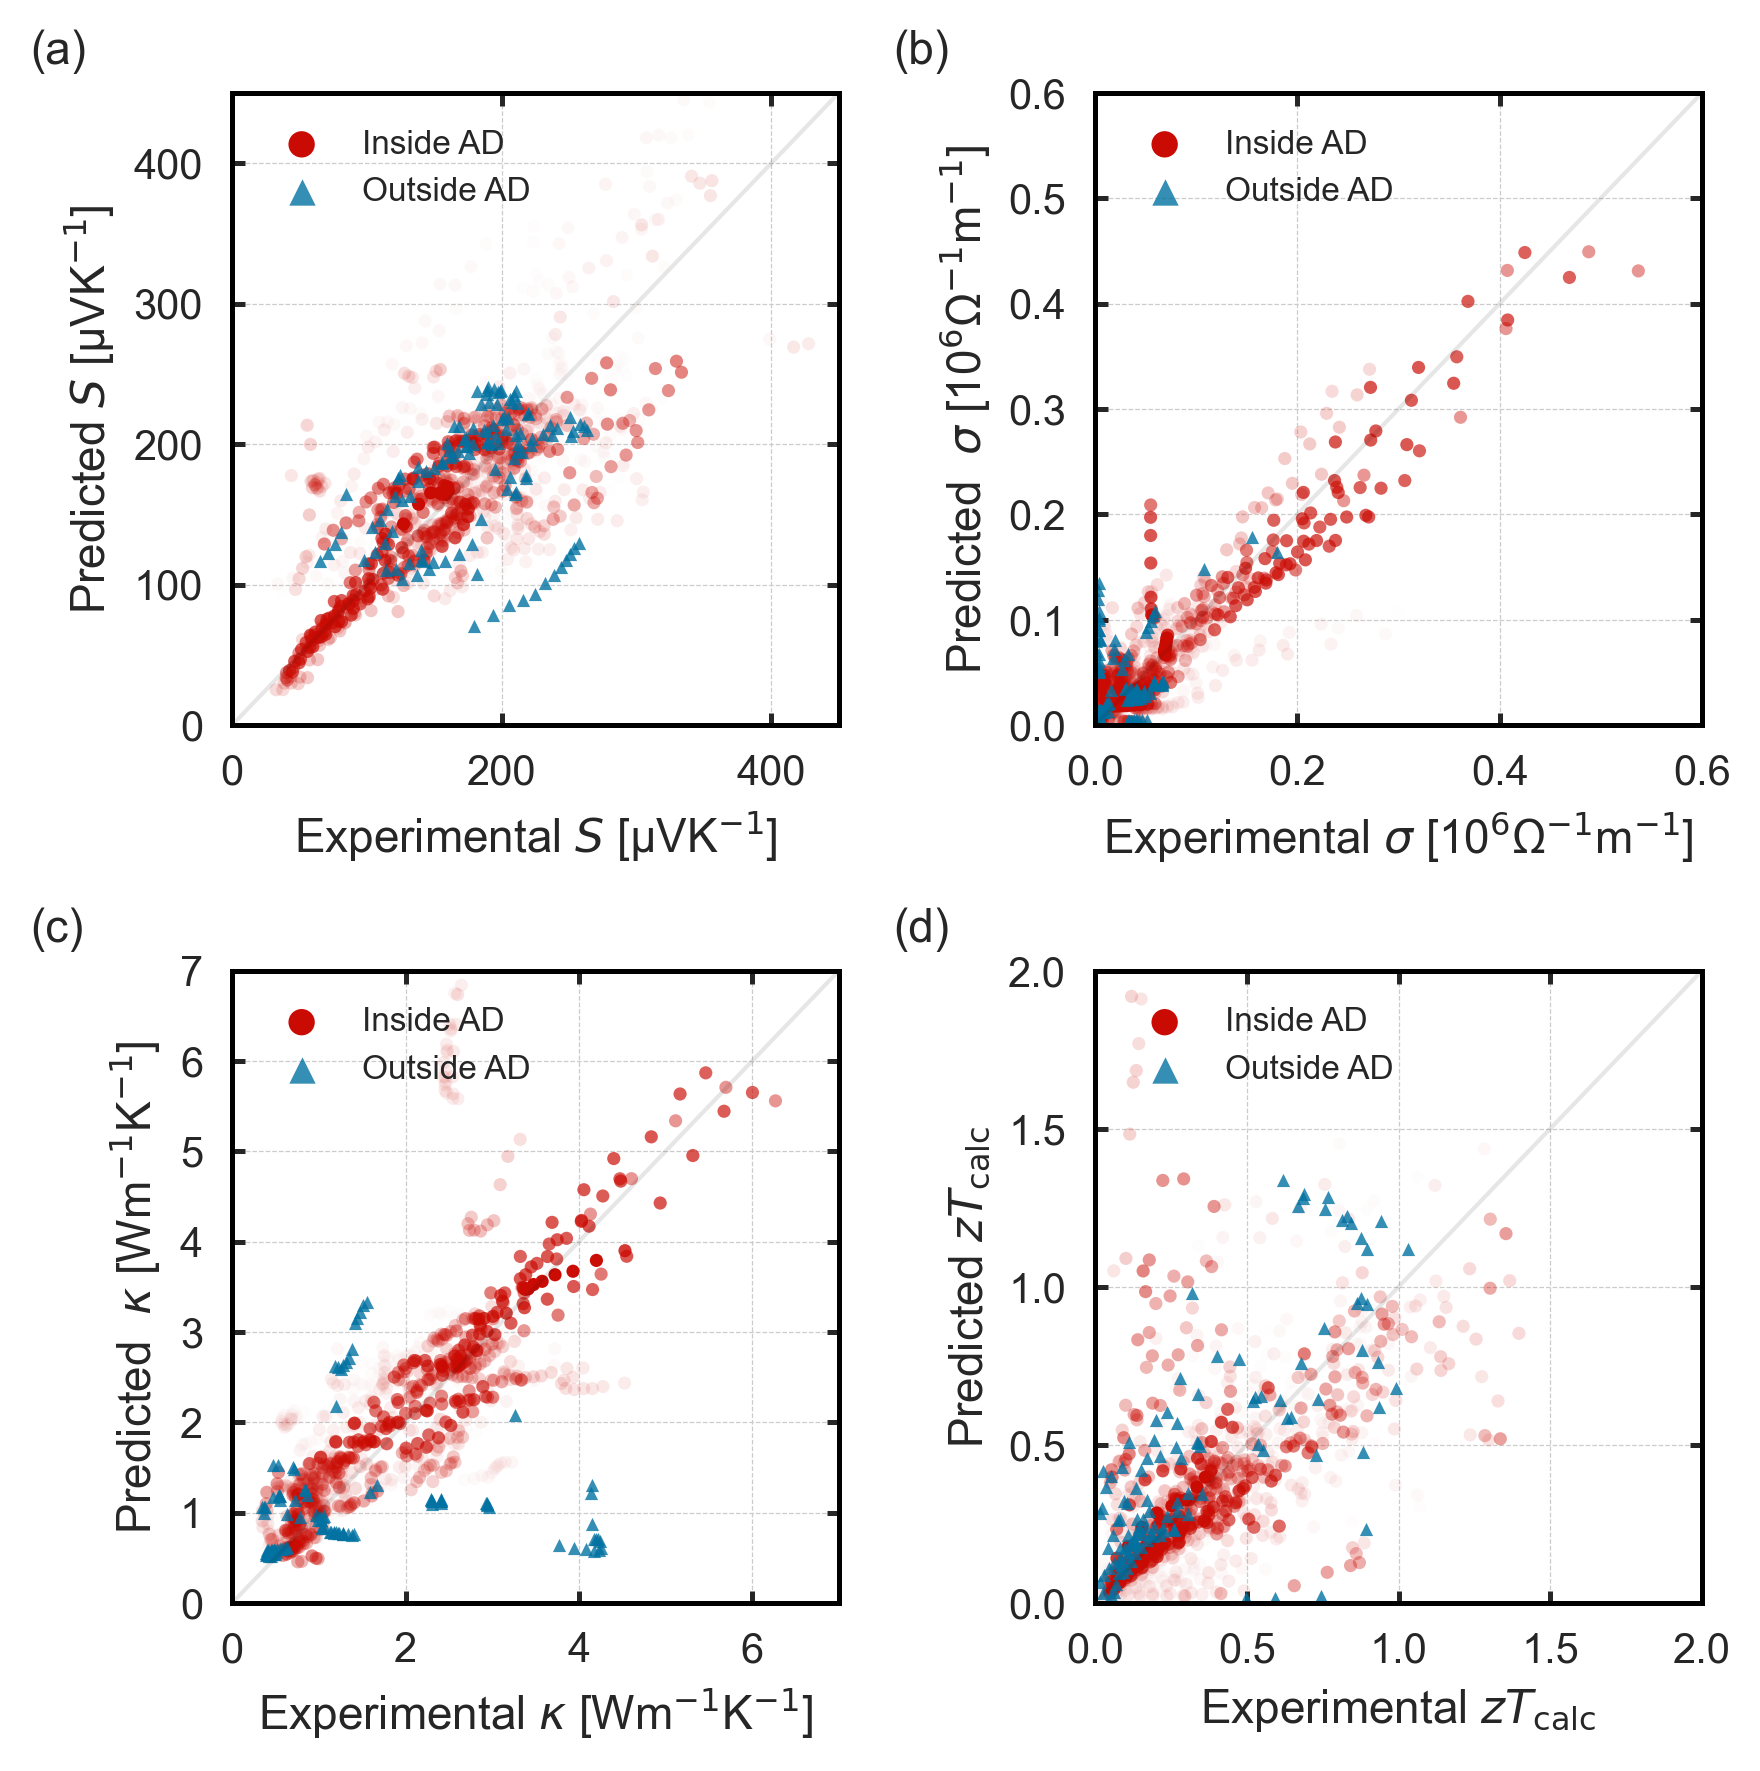

In [60]:
viz.save_parityplot_ad_starrydata_targets(targets, ad_reliability, df_test_inAD, df_test_outAD, inputsize)

In [61]:
paramstable = []
for t in targets[:-1]:
    tmp = {"property":t}
    tmp.update(mlmodel.get_params(t))
    paramstable.append(tmp)
pd.DataFrame(paramstable)[["property","max_features","max_depth","min_samples_leaf","min_samples_split","n_estimators"]]

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


,property,max_features,max_depth,min_samples_leaf,min_samples_split,n_estimators
0,Seebeck coefficient,auto,50,1,2,500
1,Electrical conductivity,auto,100,1,2,500
2,Thermal conductivity,auto,100,1,2,300


In [62]:
tick = 100

In [63]:
targets = ['Seebeck coefficient','Electrical conductivity','Thermal conductivity','ZTcalc','PFcalc']

In [64]:
mlmodel.get_errors_targets(targets, ad_reliability, df_test_inAD, df_test_outAD, inputsize, tick=tick)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [65]:
with open('models/BGMmodel', 'rb') as f:
    BGMmodel = pickle.load(f)

In [66]:
stack = cl.get_stack_ad_cluster(df_test_inAD, ad_reliability, BGMmodel, clusters, inputsize, tick=tick)

In [67]:
proplist = ["Electrical conductivity","Seebeck coefficient","PFcalc","Thermal conductivity","ZTcalc"]

In [68]:
r2dict = dict(zip(proplist,[[]]*len(proplist)))
rmsledict = dict(zip(proplist,[[]]*len(proplist)))
mapedict = dict(zip(proplist,[[]]*len(proplist)))


for prop in proplist:
    with open("errors/"+'rmslelist_'+prop.replace(" ","_")+'.pickle', 'rb') as f:
            rmsledict[prop]=pickle.load(f)
    with open("errors/"+'r2list_'+prop.replace(" ","_")+'.pickle', 'rb') as f:
            r2dict[prop]=pickle.load(f)
    with open("errors/"+'mapelist_'+prop.replace(" ","_")+'.pickle', 'rb') as f:
            mapedict[prop]=pickle.load(f)

In [69]:
xlist = [float(tick * i) for i in range(len(rmsledict[prop]))]

In [70]:
#　クラスターで行っているデータ数の多い順にソートする
sortcolor_clusteridx = np.array(clusters)[df_cluster["cluster"].value_counts().index.values]

In [71]:
sort_stack  = []
for idx in sortcolor_clusteridx:
    sort_stack.append(stack[idx])

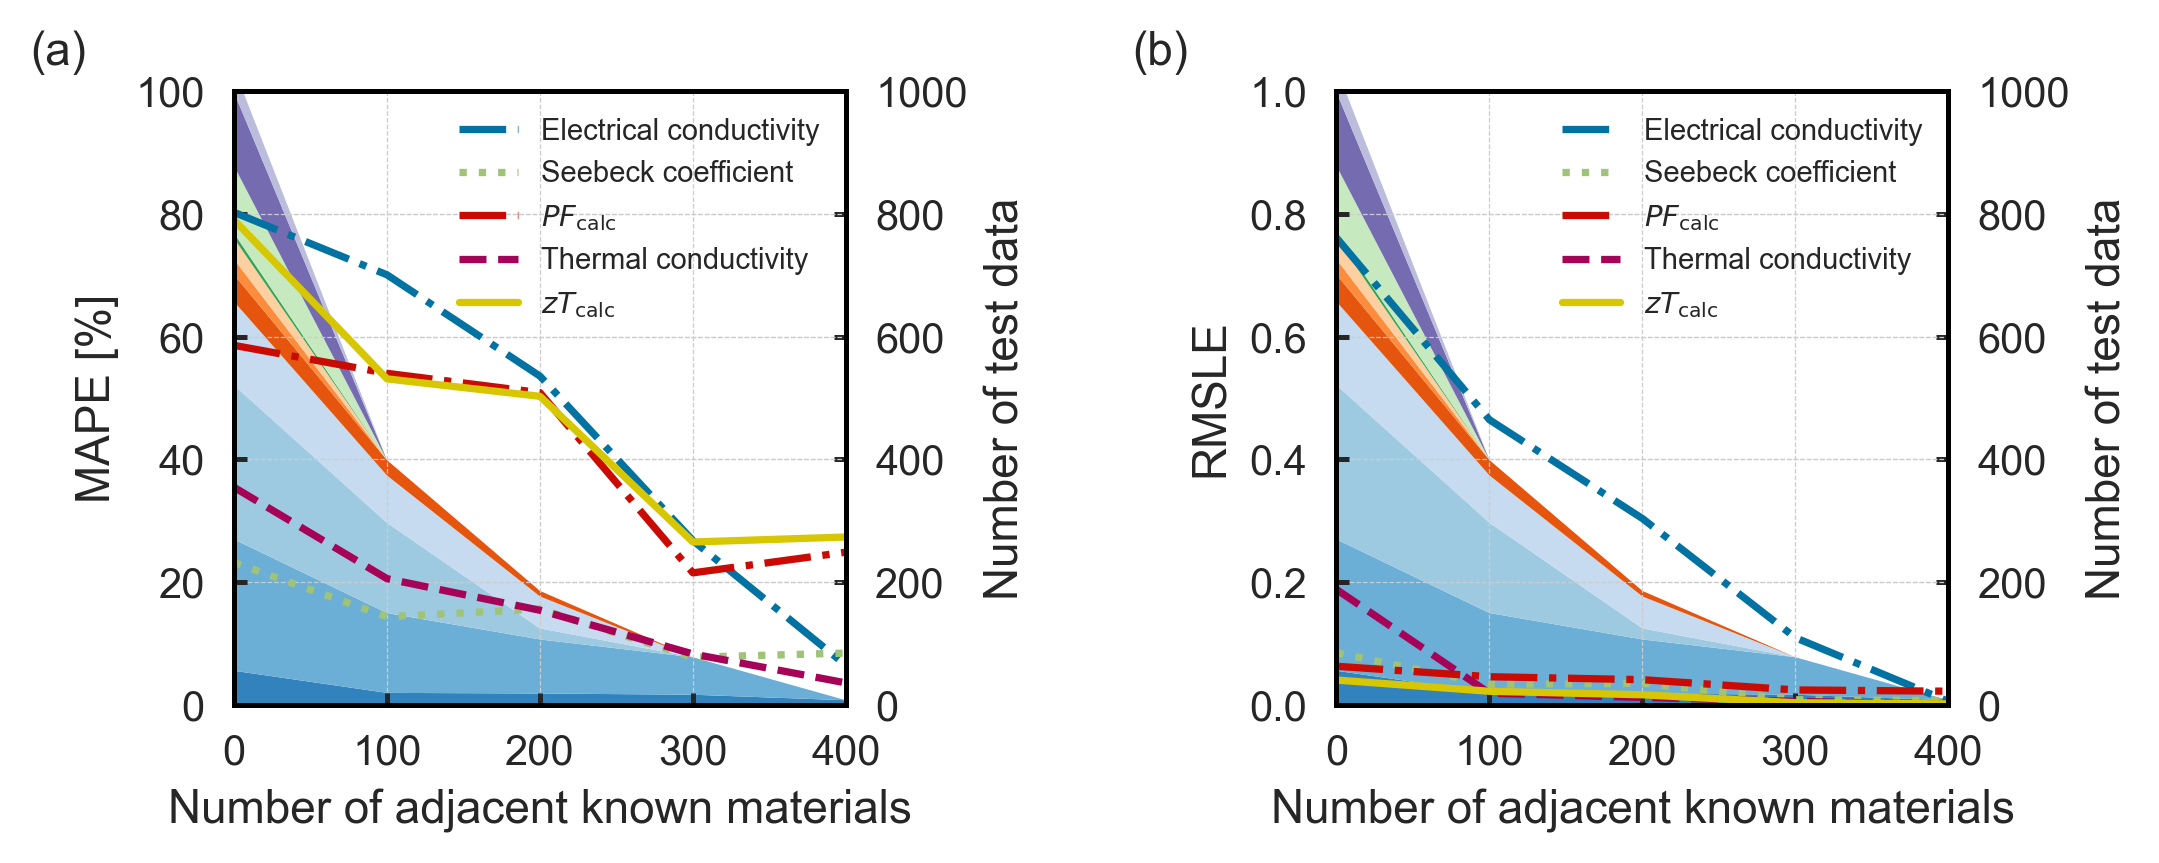

In [72]:
viz.show_errors_vs_number_of_adjacents(proplist, xlist, mapedict, rmsledict, sort_stack, matcolor)

# Materials Project

In [73]:
mpdatasets = Datasets(dbname="materials project")

In [74]:
mpdatasets.info()

Database is 'materials project'


In [75]:
df_mpall_tmp = mpdatasets.get_alldata()

In [76]:
df_mpall_tmp.shape

(83989, 11)

In [77]:
df_mpall = df_mpall_tmp.copy()

In [78]:
df_mpall["formula"] = df_mpall_tmp["formula"].apply(preprocess.set_reduce_formula)

In [79]:
#https://iric.imet-db.ru/PDF/163.pdf
#Many of the known metastable compounds in the Materials Project are within 15 meV/atom of the hull, but depending on chemistry can extend past 60 meV/atom above the hull (Sun et al. 2016).
df_mpall = df_mpall[df_mpall["e_hull"]<=0.015]

In [80]:
df_mpall = df_mpall.drop_duplicates(subset="formula")

In [81]:
df_mpall.shape

(31083, 11)

In [82]:
mp_complist = df_mpall["formula"]

In [83]:
df_mp_decriptor = feature.get_comp_descfeatures(mp_complist)#["Al3V","Si","CoSb3"]

In [84]:
df_mp_decriptor = df_mp_decriptor.dropna()

In [85]:
df_mp_decriptor = df_mp_decriptor[df_mp_decriptor != "no data"].dropna()

In [86]:
df_mp_decriptor.shape

(31023, 27)

In [87]:
df_mp_decriptor.head(3)

,composition,comp_length,compbase_length,ave:Atomic no,var:Atomic no,main_max1min1diff:Atomic no,ave:group,var:group,main_max1min1diff:group,ave:row,...,main_max1min1diff:Atomic mass,ave:Atomic radius,var:Atomic radius,main_max1min1diff:Atomic radius,ave:X,var:X,main_max1min1diff:X,ave:VEC,var:VEC,main_max1min1diff:VEC
0,In,1,1,49.0,0.0,0.0,13.0,0.0,0.0,5.0,...,0.0,1.55,0.0,0.0,1.78,0.0,0.0,3.0,0.0,0.0
1,Xe,1,1,54.0,0.0,0.0,18.0,0.0,0.0,5.0,...,0.0,0.00,0.0,0.0,2.60,0.0,0.0,8.0,0.0,0.0
2,Sr,1,1,38.0,0.0,0.0,2.0,0.0,0.0,5.0,...,0.0,2.00,0.0,0.0,0.95,0.0,0.0,2.0,0.0,0.0


In [88]:
targets = ['Seebeck coefficient']#,'Electrical conductivity','Thermal conductivity','ZTcalc','PFcalc','PF','ZT']

  0%|          | 0/1 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Loaded


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

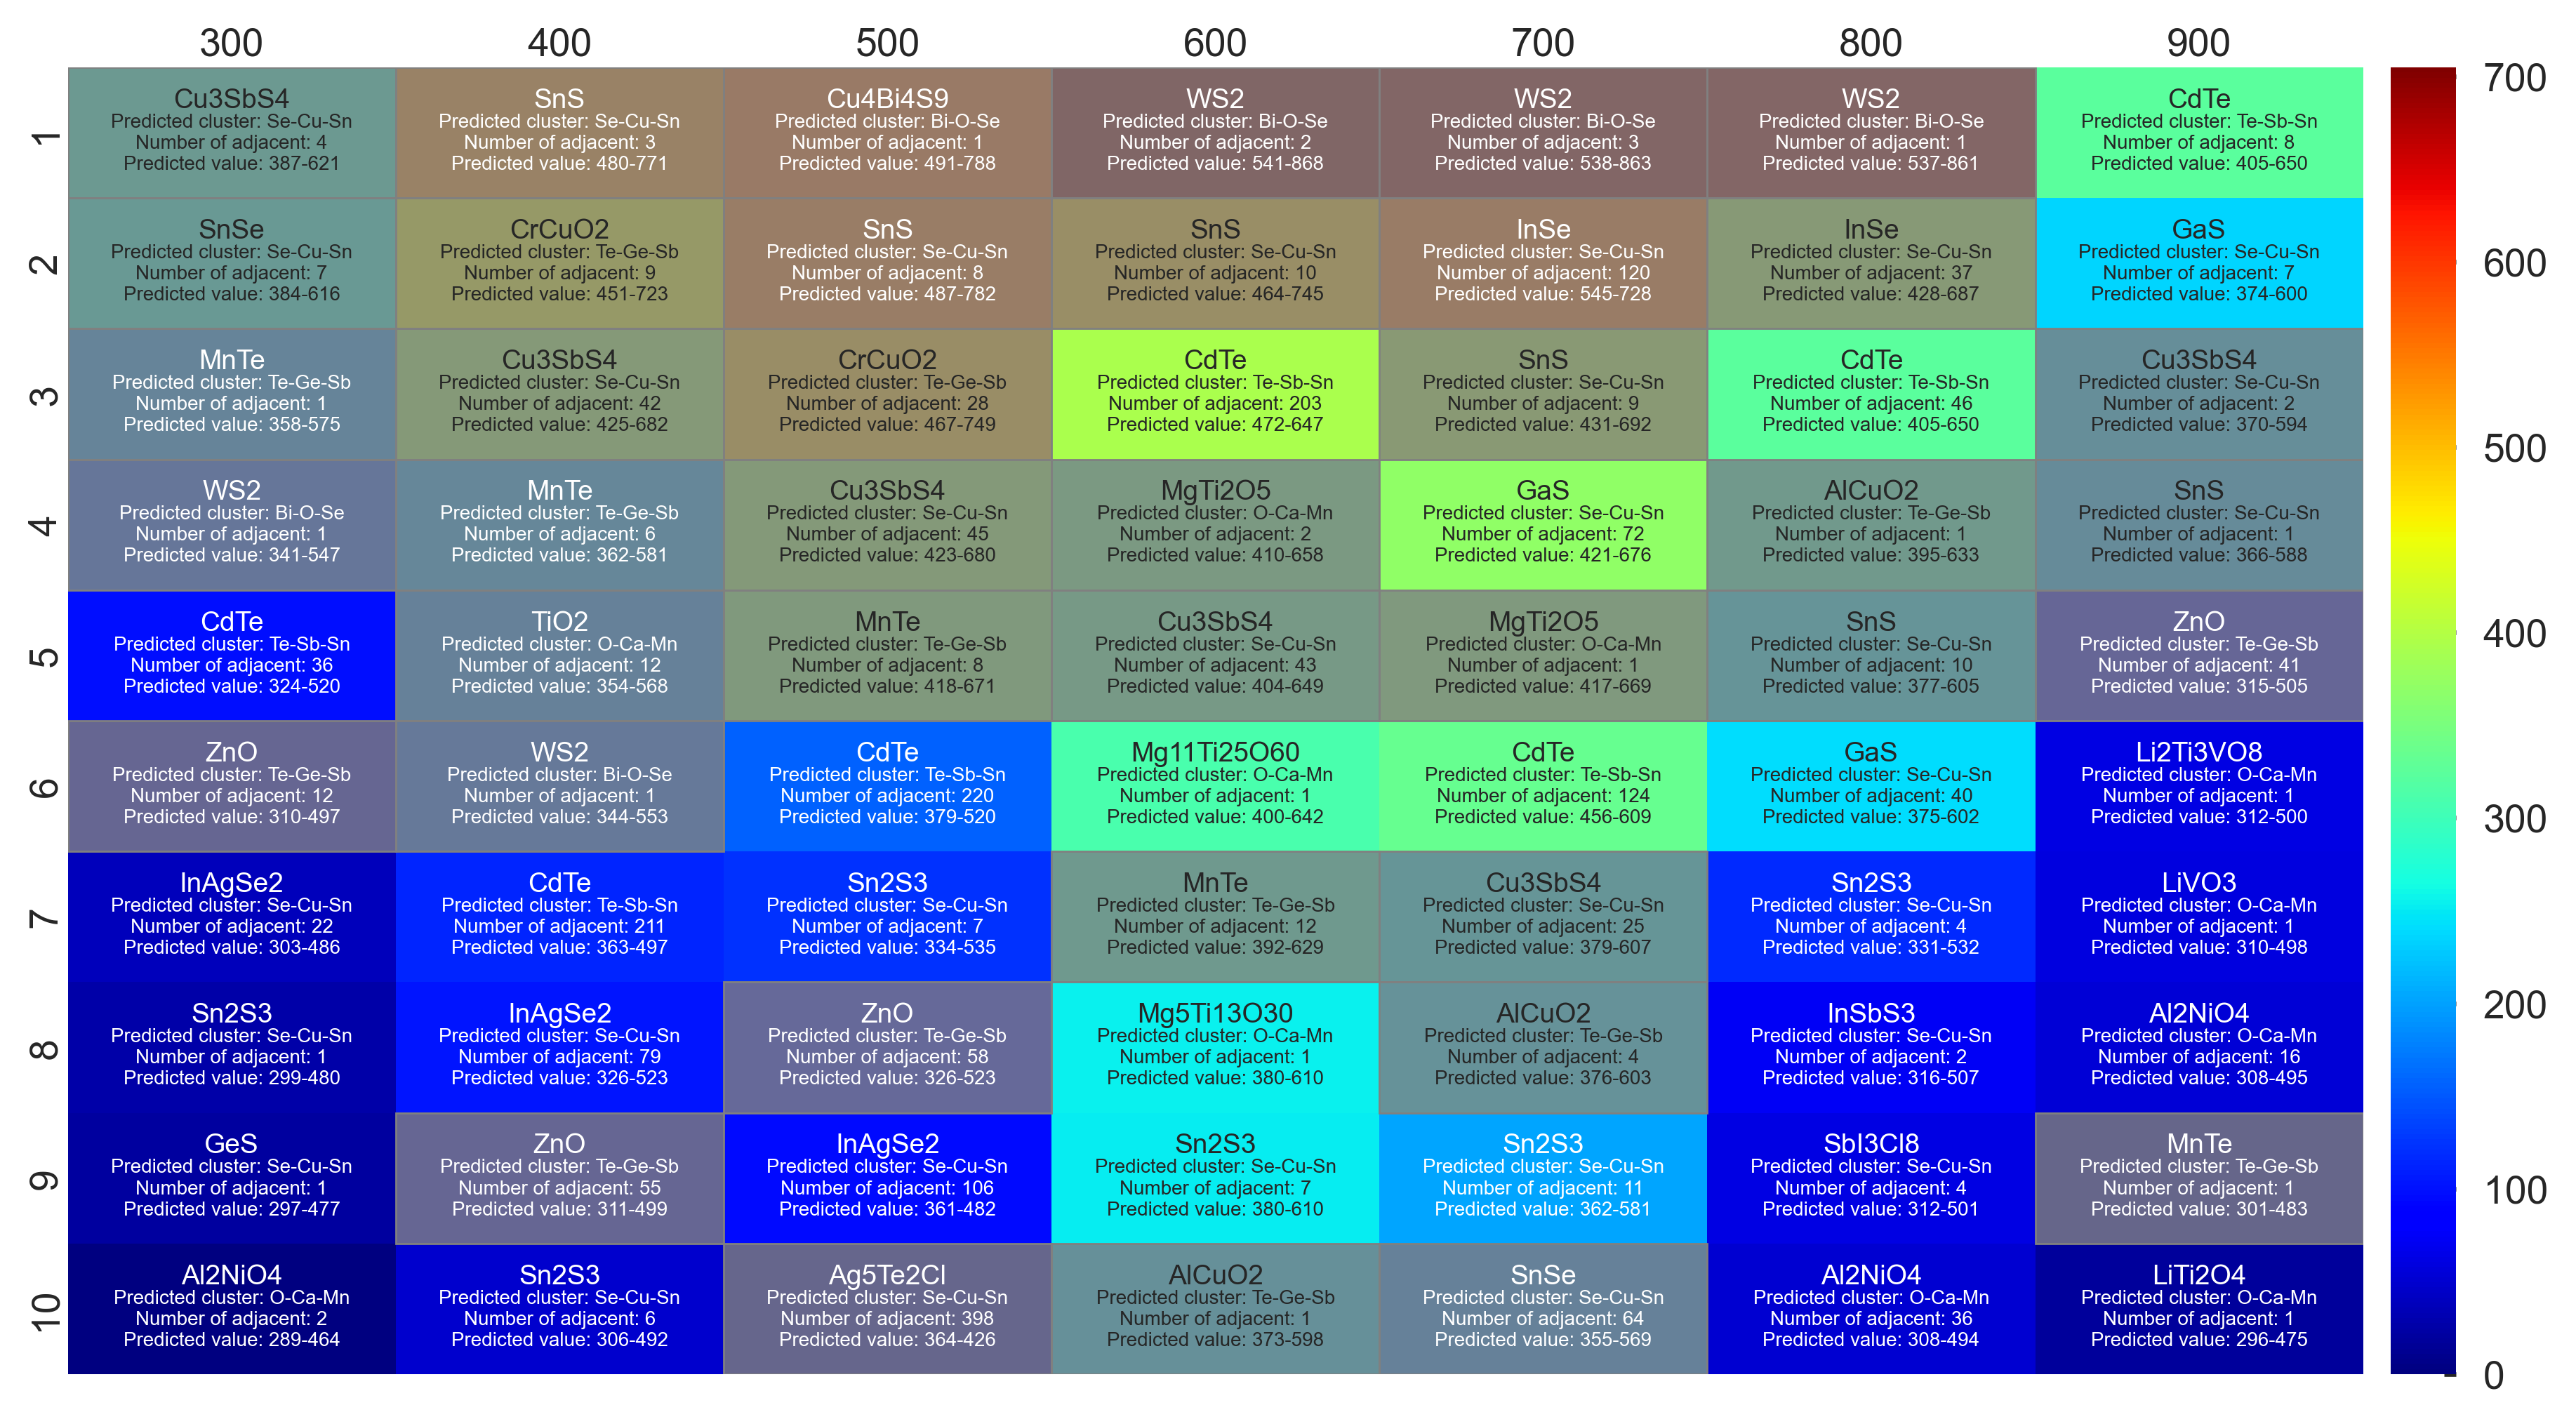

In [89]:
rank = 10
filrels = [0]
Tmin=300
Tmax=900
Ttick=100
for ranktarget in tqdm(targets):
    df_table, df_reltable, df_clstable = mlmodel.get_properties_tables(ranktarget, df_mp_decriptor, nn_train, th_train, BGMmodel, matfamily, Tmin=Tmin, Tmax=1300, Ttick=Ttick)

    df_mape = mlmodel.get_mape_table(ranktarget,df_reltable, tick)
    ascending = False
    for filrel in filrels:
        viz.show_ranking_table_detail(df_table, df_mape, df_reltable, df_clstable, df_data,filrel=filrel, rank=rank, Tmin=Tmin, Tmax=Tmax, Ttick=Ttick, height=5, width=10,ascending=ascending, imagename="rank"+str(rank)+"_"+ranktarget+"_filrel"+str(filrel))

